In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class EmbeddingDataset(Dataset):
    def __init__(self, parquet_file):
        # Загрузка предобработанных данных
        self.data = pd.read_parquet(parquet_file)
        self.labels = self.data['label'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        emb_r50 = self.data.iloc[idx]['emb_r50']
        emb_r100 = self.data.iloc[idx]['emb_r100']
        label = self.labels[idx]
        # Конвертируем эмбеддинги в тензоры
        emb_r50 = torch.tensor(emb_r50, dtype=torch.float32)
        emb_r100 = torch.tensor(emb_r100, dtype=torch.float32)
        return emb_r50, emb_r100, label
    
    
class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim=512, output_dim=512):
        super(EmbeddingMapper, self).__init__()
        self.lin1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024))
        self.lin2 = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048))
        self.lin3 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024))
        self.lin4 = nn.Linear(1024, output_dim)
        
    def forward(self, x):
        # print(x.shape)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        return x
    
def cosine_similarity_torch(x1, x2):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(x1, x2)

In [4]:
batch_size = 256
test_dataset = EmbeddingDataset('test_embeddings.parquet')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = torch.device('cpu')

model = EmbeddingMapper(input_dim=512, output_dim=512).to(device)
model.load_state_dict(torch.load(r"checkpoints\refactor_2_stage2_embedding_mapper8.pth"))

<All keys matched successfully>

In [5]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    total_cosine_sim = 0.0
    total_samples = 0
    similarities = []
    for inputs, targets, _ in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        cosine_sim = cosine_similarity_torch(outputs, targets)
        similarities.append(cosine_sim.detach().cpu().numpy())
        total_cosine_sim += cosine_sim.sum().item()
        total_samples += inputs.size(0)

(array([[  0.,   0.,   0.,   0.,   2.,   1.,   3.,  33., 119.,  98.],
        [  1.,   0.,   1.,   0.,   0.,   1.,   7.,  29., 127.,  90.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   2.,   8.,  74., 172.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   5.,   9.,  91., 151.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   8.,  88., 159.],
        [  0.,   0.,   0.,   1.,   1.,   0.,   3.,  13., 106., 132.],
        [  0.,   0.,   0.,   0.,   2.,   1.,   5.,  39., 121.,  88.],
        [  0.,   0.,   0.,   0.,   1.,   1.,   2.,   9.,  65., 178.],
        [  0.,   0.,   1.,   0.,   1.,   1.,   3.,  12.,  46., 192.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   2.,  15.,  84., 154.],
        [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,  39., 215.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,  30., 223.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   3.,  12.,  80., 160.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   1.,  12., 125., 117.],
        [  0.,   0.,

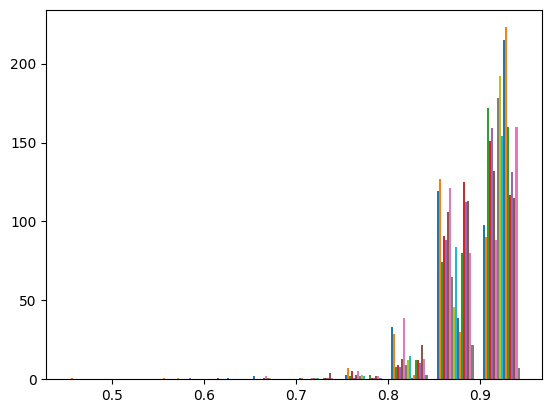

In [6]:
plt.hist(similarities)